In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

!curl -O https://lazyprogrammer.me/course_files/airline_passengers.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2036  100  2036    0     0   2111      0 --:--:-- --:--:-- --:--:--  2112


In [2]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)
df['LogPassengers'] = np.log(df['Passengers'])
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [3]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [4]:
series = df['DiffLogPassengers'].to_numpy()[1:]
T = 10
X = [series[t:t+T] for t in range(len(series) - T)]
Y = [series[t+T] for t in range(len(series) - T)]

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
X.shape, Y.shape

((133, 10), (133,))

In [5]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [6]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.6837135048453121

In [7]:
lr.score(Xtest, Ytest)

0.6492870172668169

In [8]:
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

# You can't predict first T values
train_idx[:T+1] = False

In [9]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

# Last-known train value
last_train = train.iloc[-1]['LogPassengers']

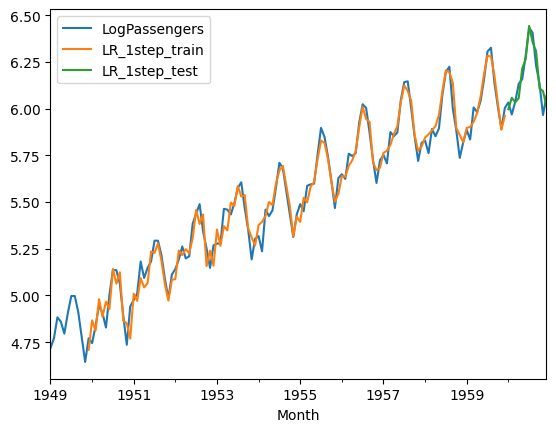

In [10]:
df.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + lr.predict(Xtest)

# plot 1-step forecast
df[['LogPassengers', 'LR_1step_train', 'LR_1step_test']].plot();

In [11]:
# Perform multi-step forecasting
multistep_preds = []

# First test input
last_x = Xtest[0]

while len(multistep_preds) < Ntest:
    p = lr.predict(last_x.reshape(1, -1))[0]
    multistep_preds.append(p)
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

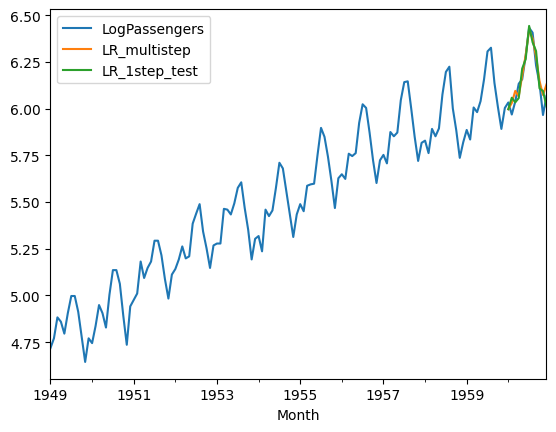

In [12]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = last_train + np.cumsum(multistep_preds)
df[['LogPassengers', 'LR_multistep', 'LR_1step_test']].plot();

In [13]:
Tx, Ty = T, Ntest
X = [series[t:t+Tx] for t in range(len(series) - Tx - Ty + 1)]
Y = [series[t+Tx:t+Tx+Ty] for t in range(len(series) - Tx - Ty + 1)]

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10) Y.shape (122, 12)


In [14]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [15]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.8141637147930583

In [16]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

0.7690077978619653

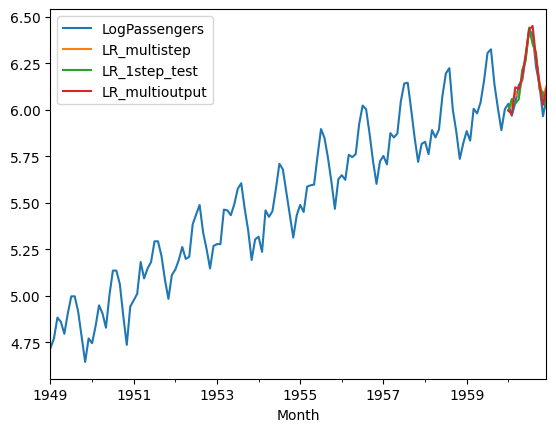

In [17]:
df.loc[test_idx, 'LR_multioutput'] = last_train + \
    np.cumsum(lr.predict(Xtest_m).flatten())
    
# plot all forecasts
cols = ['LogPassengers', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols].plot();

In [18]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'LR_multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.007109281288502549
multi-output MAPE: 0.005245261617574856


Test other models

In [19]:
def one_step_and_multistep_forecast(model, name):
    model.fit(Xtrain, Ytrain)
    print("One-step forecast:", name)

    # store 1-step forecast
    df.loc[train_idx, f'{name}_1step_train'] = \
    prev[train_idx] + model.predict(Xtrain)
    df.loc[test_idx, f'{name}_1step_test'] = \
    prev[test_idx] + model.predict(Xtest)

    # generate multi-step forecast
    multistep_predictions = []

    # first test input
    last_x = Xtest[0]

    while len(multistep_predictions) < Ntest:
        p = model.predict(last_x.reshape(1, -1))[0]

        # update the predictions list
        multistep_predictions.append(p)

        # make the new input
        last_x = np.roll(last_x, -1)
        last_x[-1] = p

    # store multi-step forecast
    df.loc[test_idx, f'{name}_multistep_test'] = \
    last_train + np.cumsum(multistep_predictions)

    # MAPE of multi-step forecast
    mape = mean_absolute_percentage_error(
        test_log_pass, df.loc[test_idx, f'{name}_multistep_test'])
    print("Test MAPE (multi-step):", mape)

    # plot 1-step and multi-step forecast
    cols = [
        'LogPassengers',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test'
    ]
    df[cols].plot();

One-step forecast: SVR
Test MAPE (multi-step): 0.012149122102392764


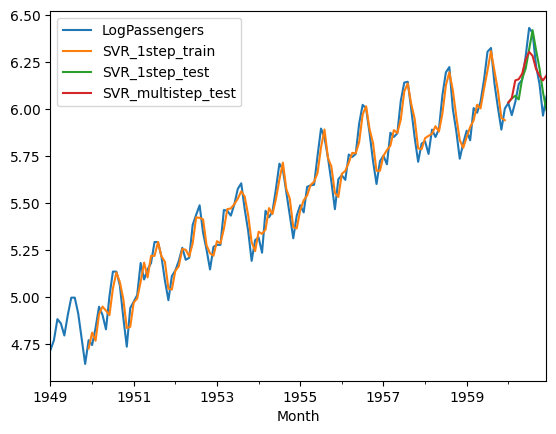

In [20]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Test MAPE (multi-step): 0.005459391992746897


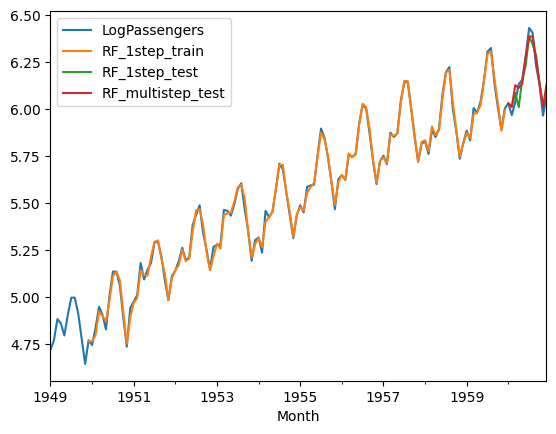

In [21]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [26]:
def multi_output_forecast(model, name):
    model.fit(Xtrain_m, Ytrain_m)

    # save multi-output forecast to dataframe
    df.loc[test_idx, f'{name}_multioutput'] = \
    last_train + np.cumsum(model.predict(Xtest_m).flatten())

    mape = mean_absolute_percentage_error(
        test_log_pass, df.loc[test_idx, f'{name}_multioutput'])
    print("Test MAPE (multi-output):", mape)

    # plot all forecasts
    # assume that previous functions have been run
    cols = [
        'LogPassengers',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test',
        f'{name}_multioutput',
    ]
    df[cols].plot();

In [27]:
# Use a Wrapper to let SVM support multi-output
class SVRWrapper:
    def __init__(self, h, **args):
        self.h = h
        self.models = [SVR(**args) for _ in range(h)]
        
    def fit(self, X, Y):
        for k in range(self.h):
            self.models[k].fit(X, Y[:, k])
    
    def predict(self, X):
        P = [m.predict(X) for m in self.models]
        return np.hstack(P)

Test MAPE (multi-output): 0.010731361803536803


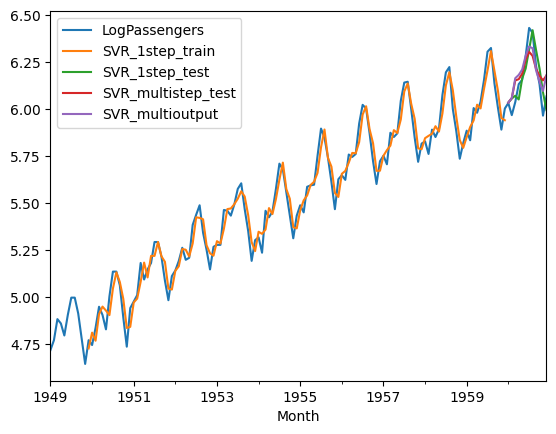

In [28]:
multi_output_forecast(SVRWrapper(Ntest), "SVR")

Test MAPE (multi-output): 0.005278503339627263


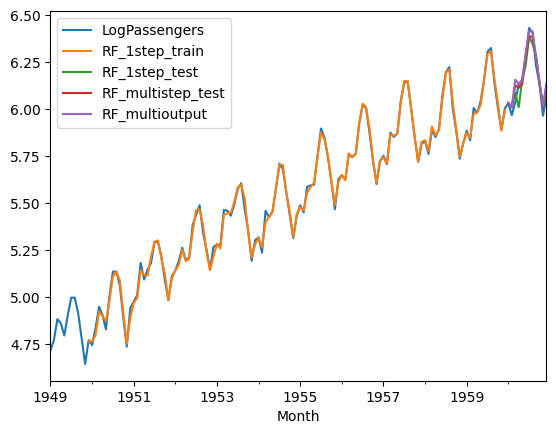

In [29]:
multi_output_forecast(RandomForestRegressor(), "RF")

Test MAPE (multi-output): 0.017918498154557677


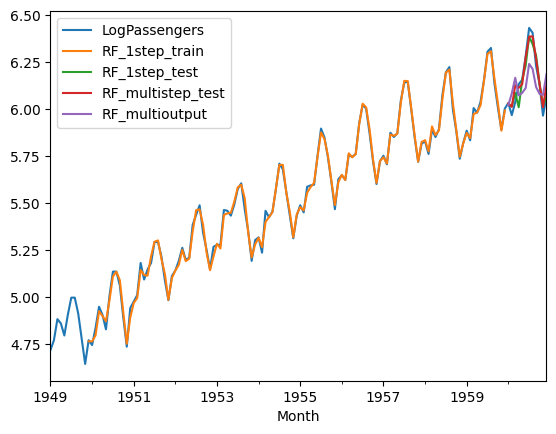

In [32]:
multi_output_forecast(MLPRegressor(hidden_layer_sizes=64), "RF")